In [2]:
from google.colab import drive
from google.colab import files

#Read and write files directly from google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#install packages missing from the Colab environment
!pip install geopandas
!pip install rasterio
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     | 188.8MB 3.6MB/s
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756017 sha256=0cefdd6cc24a528169ad1e357d5a85729402ee326c089e21c8874374f7a33a06
  Stored in directory: /tmp/pip-ephem-wheel-cache-ossjj_1w/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [0]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import mapping, shape
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import math

#from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
#import matplotlib.font_manager as fm

In [0]:
#Define a Bounding Boxes class to store all calculations and methods for plotting
class Bounding_Boxes:

  #Instantiate Bounding_Boxes class using vector data - this class is written specifically to accept volcano specific data
  def __init__(self, vector_data):
    
    #Add vector_data attribute to inspect original vector data
    self.vector_data = vector_data
    
    bbox = {}
    bbox['Archipelago'] = vector_data.total_bounds
    
    isabela_list = ['Darwin', 'Alcedo', 'Ecuador', 'South', 'Wolf']
    
    bbox['Isabela'] = vector_data[vector_data['Name'].isin(isabela_list)].total_bounds
    
    for island in list(vector_data.Name.unique()):
      bbox[island] = vector_data[vector_data['Name']==island].envelope
    self.bboxes = bbox
    
    #Add volcano_names class to inspect all unique volcano names (useful for plotting)
    volcano_names = list(vector_data.Name.unique()) + ['Archipelago'] + ['Isabela']
    self.volcano_names = volcano_names
      
  #Define a method to create matplotlib compatible xlim
  def x_lim_island(self, island, zoom_factor=0.15):
    
    #Define the factor by which to zoom out x axis (this could be made into two zooms L & R)
    #z_factor = 0.15 means that 15% of the total boundign box will be added to both sides
    #This scales with the size of the island to add a border to all plots
    z_factor = zoom_factor
    
    #Archipelago is a ndarray data type not a Shapely Polygon
    if island in ['Archipelago', 'Isabela']:
      xmin = self.bboxes[island][0]
      xmax = self.bboxes[island][2]
    
      zoom = (xmax - xmin) * z_factor
      
      #Returns xlim ready for the plt.xlim function
      return(xmin - zoom, xmax + zoom)
    
    #Extract coordinates from Shapely Polygon bounding boxes
    else:
      xmin = mapping(self.bboxes[island])['bbox'][0]
      xmax = mapping(self.bboxes[island])['bbox'][2]
  
      zoom = (xmax - xmin) * z_factor
    
      #Returns xlim ready for the plt.xlim function    
      return(xmin - zoom, xmax + zoom)

  #Copy of x_lim_island for the y axis
  def y_lim_island(self, island, zoom_factor=0.15):
  
    z_factor = zoom_factor
  
    if island in ['Archipelago', 'Isabela']:
      ymin = self.bboxes[island][1]
      ymax = self.bboxes[island][3]
    
      zoom = (ymax - ymin) * z_factor
      
      return(ymin - zoom, ymax + zoom)
  
    else:
      ymin = mapping(self.bboxes[island])['bbox'][1]
      ymax = mapping(self.bboxes[island])['bbox'][3]
    
      zoom = (ymax - ymin) * z_factor
  
      return(ymin - zoom, ymax + zoom) 

In [0]:
#Import datasets for mapping
volcanoes = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/Shp/Island_volcanos_wgs.shp', 
                          driver='ESRI Shapefile')

coastline = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/useful general mapping data - elevation and perimeter/Linea_Costa/PERFIL_Project.shp', 
                       driver='ESRI Shapefile')

hillshade = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/tmp/hillshade.tif')

island_boxes = Bounding_Boxes(volcanoes)

In [0]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

[]

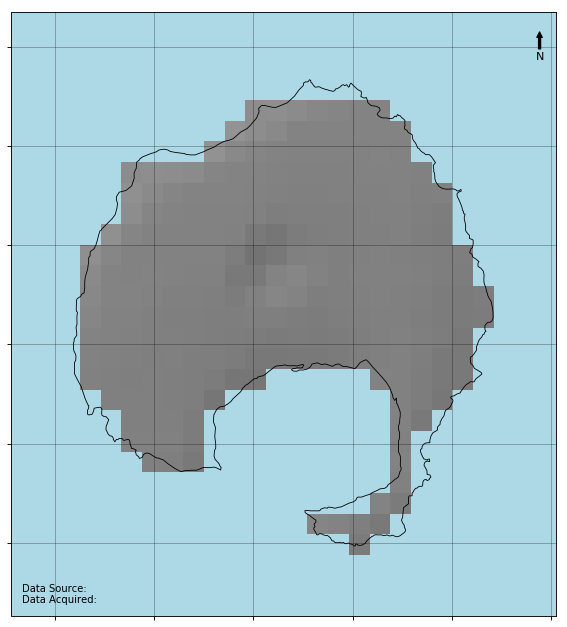

In [300]:
island_to_plot = 'Genovesa'

plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["figure.dpi"] = 80

#Add data
ax = coastline.geometry.plot(color='k', linewidth=0.75)

ax.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

#Add styling
ax.grid(True, color='k', alpha=0.3)
ax.set_facecolor('lightblue')

x_diff = island_boxes.x_lim_island(island_to_plot)[1] - island_boxes.x_lim_island(island_to_plot)[0]
arrow_x = island_boxes.x_lim_island(island_to_plot)[1] - (x_diff * arrow_buffer)
y_diff = island_boxes.y_lim_island(island_to_plot)[1] - island_boxes.y_lim_island(island_to_plot)[0]
arrow_y = island_boxes.y_lim_island(island_to_plot)[1] - (y_diff * arrow_buffer)

text_x_buffer = x_diff / 50
text_y_buffer = y_diff / 50

ax.text(x=island_boxes.x_lim_island(island_to_plot)[0] + text_x_buffer,
        y=island_boxes.y_lim_island(island_to_plot)[0] + text_y_buffer,
        s='Data Source:\nData Acquired:', size=9)

ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, (arrow_y-(y_diff/28))), arrowprops=dict(arrowstyle='simple', fc='k'), clip_on=True)

ax.text(x=arrow_x, y=(arrow_y-(y_diff/20)),
        s='N', horizontalalignment='center')

#arrowstyle="->"
#Additional formatting
plt.xlim(island_boxes.x_lim_island(island_to_plot))
plt.ylim(island_boxes.y_lim_island(island_to_plot))

ax.axes.get_xaxis().set_ticklabels([])
ax.axes.get_yaxis().set_ticklabels([])

In [0]:
#Will have to package everything as a package if want to import lots of classes and variety of dependencies

In [0]:
#Test plotting each island to check location of scalebar etc.
def subtle_island(coastline, hillshade, island_to_plot):
  
  plt.rcParams["figure.figsize"] = [20,10]
  plt.rcParams["figure.dpi"] = 80

  #Add data
  ax = coastline.geometry.plot(color='k', linewidth=0.75)
  
  gray_cmap = plt.get_cmap('gray')
  subtle_gray_cmap = truncate_colormap(gray_cmap, 0.8, 1.0)
  
  ax.imshow(hillshade.read(1), 
            extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
            cmap=subtle_gray_cmap)

  #Add styling
  ax.grid(True, color='k', alpha=0.3)
  ax.set_facecolor('whitesmoke')

  x_diff = island_boxes.x_lim_island(island_to_plot)[1] - island_boxes.x_lim_island(island_to_plot)[0]
  arrow_x = island_boxes.x_lim_island(island_to_plot)[1] - (x_diff * arrow_buffer)
  y_diff = island_boxes.y_lim_island(island_to_plot)[1] - island_boxes.y_lim_island(island_to_plot)[0]
  arrow_y = island_boxes.y_lim_island(island_to_plot)[1] - (y_diff * arrow_buffer)

  text_x_buffer = x_diff / 50
  text_y_buffer = y_diff / 50

  ax.text(x=island_boxes.x_lim_island(island_to_plot)[0] + text_x_buffer,
          y=island_boxes.y_lim_island(island_to_plot)[0] + text_y_buffer,
          s='Data Source:\nData Acquired:', size=9)

  ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, (arrow_y-(y_diff/28))), arrowprops=dict(arrowstyle='simple', fc='k'), clip_on=True)

  ax.text(x=arrow_x, y=(arrow_y-(y_diff/20)),
          s='N', horizontalalignment='center')

  
  #Additional formatting
  plt.xlim(island_boxes.x_lim_island(island_to_plot))
  plt.ylim(island_boxes.y_lim_island(island_to_plot))

  ax.axes.get_xaxis().set_ticklabels([])
  ax.axes.get_yaxis().set_ticklabels([])

In [0]:
for island in island_boxes.volcano_names:
  color_map = subtle_island(coastline, hillshade, island)
  
  path = 'drive/My Drive/Hamish mapping/Plot_Tests/'
  file_name = island + '_subtle.png'  
  plt.savefig(path + file_name)

In [306]:
#Try some out with additonal vector data
occurence_csv = pd.read_csv('drive/My Drive/Hamish mapping/Hamish mapping/Occurence data to Oct 2019/Galapagos Tortoise Movement Ecology Programme_2009-2018.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
occurence_df = gpd.GeoDataFrame(occurence_csv,
                                geometry=gpd.points_from_xy(occurence_csv['location-long'], occurence_csv['location-lat']))

In [337]:
print(list(occurence_df))

['event-id', 'visible', 'timestamp', 'location-long', 'location-lat', 'eobs:battery-voltage', 'eobs:fix-battery-voltage', 'eobs:horizontal-accuracy-estimate', 'eobs:key-bin-checksum', 'eobs:speed-accuracy-estimate', 'eobs:start-timestamp', 'eobs:status', 'eobs:temperature', 'eobs:type-of-fix', 'eobs:used-time-to-get-fix', 'ground-speed', 'heading', 'height-above-ellipsoid', 'manually-marked-outlier', 'sensor-type', 'individual-taxon-canonical-name', 'tag-local-identifier', 'individual-local-identifier', 'study-name', 'geometry']


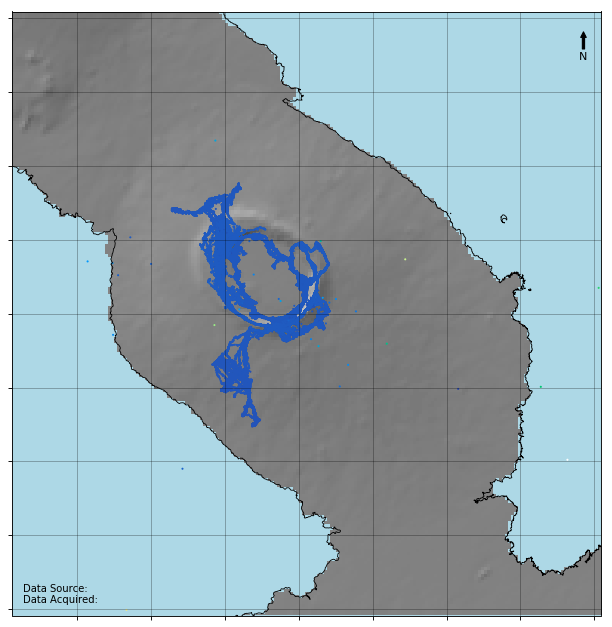

In [336]:
island_to_plot = 'Alcedo'

plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["figure.dpi"] = 80

#Add data
ax = coastline.geometry.plot(color='k', linewidth=0.75)

ax.scatter(occurence_csv['location-long'], occurence_csv['location-lat'],
           c=occurence_csv['height-above-ellipsoid'], cmap='terrain', s=0.75)

ax.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

#Add styling
ax.grid(True, color='k', alpha=0.3)
ax.set_facecolor('lightblue')

x_diff = island_boxes.x_lim_island(island_to_plot)[1] - island_boxes.x_lim_island(island_to_plot)[0]
arrow_x = island_boxes.x_lim_island(island_to_plot)[1] - (x_diff * arrow_buffer)
y_diff = island_boxes.y_lim_island(island_to_plot)[1] - island_boxes.y_lim_island(island_to_plot)[0]
arrow_y = island_boxes.y_lim_island(island_to_plot)[1] - (y_diff * arrow_buffer)

text_x_buffer = x_diff / 50
text_y_buffer = y_diff / 50

ax.text(x=island_boxes.x_lim_island(island_to_plot)[0] + text_x_buffer,
        y=island_boxes.y_lim_island(island_to_plot)[0] + text_y_buffer,
        s='Data Source:\nData Acquired:', size=9)

ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, (arrow_y-(y_diff/28))), arrowprops=dict(arrowstyle='simple', fc='k'), clip_on=True)

ax.text(x=arrow_x, y=(arrow_y-(y_diff/20)),
        s='N', horizontalalignment='center')

#arrowstyle="->"
#Additional formatting
plt.xlim(island_boxes.x_lim_island(island_to_plot))
plt.ylim(island_boxes.y_lim_island(island_to_plot))

ax.axes.get_xaxis().set_ticklabels([])
ax.axes.get_yaxis().set_ticklabels([])

path = 'drive/My Drive/Hamish mapping/Plot_Tests/'
file_name = island_to_plot + '_vector_test.png'  
plt.savefig(path + file_name)

In [0]:
#add additional information, scale bar - spend a little more time on this
#  - having lots of trouble with scalebar

#create map with 'subtle' theme for plotting other raster data

#Wrap everything into a class, with theme included - i.e.
#create class method, colormap.add_data(data, etc.)
#class methods - 
  #add xy data
  #add raster

#discuss theme/styling with James

#Subtle theme:
  #ocean = 'whitesmoke'

  #hillshade:
  #gray_cmap = plt.get_cmap('gray')
  #subtle_gray_cmap = truncate_colormap(gray_cmap, 0.8, 1.0)

In [0]:
!pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

In [0]:
def spherical_distance_km(lat_min, long_min, lat_max, long_max):
  d_to_rad = math.pi/180.0
  
  phi_min = (90.0 - lat_min)*d_to_rad
  phi_max = (90.0 - lat_max)*d_to_rad
  
  theta_min = long_min*d_to_rad
  theta_max = long_max*d_to_rad
  
  cos = (math.sin(phi_min)*math.sin(phi_max)*math.cos(theta_min - theta_max) + math.cos(phi_min)*math.cos(phi_max))
  arc = math.acos(cos)
  
  length_km = arc * 40075
  
  return(length_km)

my_dpi = 96
pixel_width = 1024
pixel_height = 768

map_width_km = spherical_distance_km(island_boxes.y_lim_island('Archipelago')[0], 
                                 island_boxes.x_lim_island('Archipelago')[0], 
                                 island_boxes.y_lim_island('Archipelago')[1], 
                                 island_boxes.x_lim_island('Archipelago')[1])


pixel_km = map_width_km/pixel_width

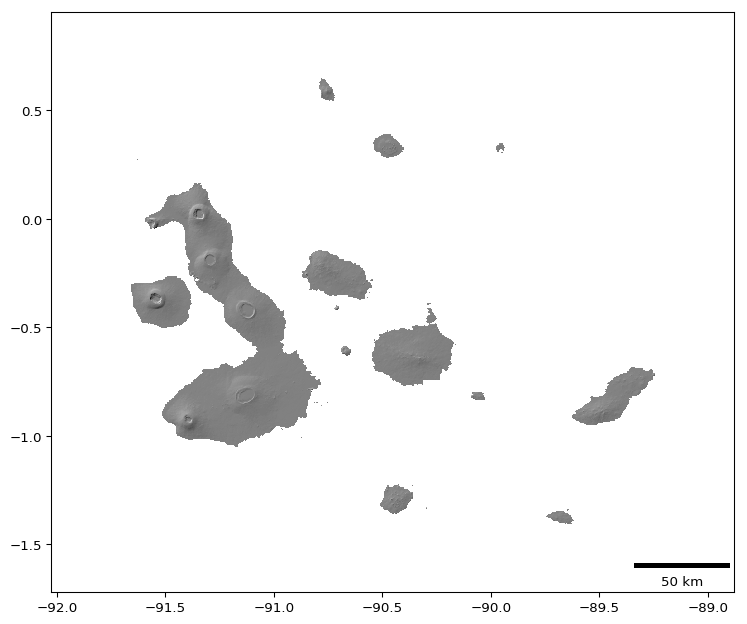

In [452]:
#Be careful with this when moving into publishing - need to know dpi to calculate scalebar
island_to_plot = 'Archipelago'

plt.figure(figsize=(pixel_width/my_dpi, pixel_height/my_dpi), dpi=my_dpi)

#scalebar = ScaleBar((map_width_km), units='km', length_fraction=0.2, location='lower right')
scalebar = ScaleBar(dx=pixel_km*40, units='km', length_fraction=0.2, location='lower right', frameon=False)
plt.gca().add_artist(scalebar)

plt.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

plt.xlim(island_boxes.x_lim_island(island_to_plot))
plt.ylim(island_boxes.y_lim_island(island_to_plot))

plt.show()

In [395]:
map_width_km/pixel_width * 100

39.03761443613454

In [382]:
hillshade.bounds

BoundingBox(left=-92.14, bottom=-1.601308774, right=-89.148261012, top=0.83)

In [364]:
#need to figure out the size of one x axis pixel
#need:
  
  #Number of pixels in whole plot - can set this manually

pixel_width

  #convert degrees to km

def spherical_distance_km(lat_min, long_min, lat_max, long_max):
  d_to_rad = math.pi/180.0
  
  phi_min = (90.0 - lat_min)*d_to_rad
  phi_max = (90.0 - lat_max)*d_to_rad
  
  theta_min = long_min*d_to_rad
  theta_max = long_max*d_to_rad
  
  cos = (math.sin(phi_min)*math.sin(phi_max)*math.cos(theta_min - theta_max) + math.cos(phi_min)*math.cos(phi_max))
  arc = math.acos(cos)
  
  length_km = arc * 40075
  
  return(length_km)

map_width_km = spherical_distance_km(island_boxes.y_lim_island(island_to_plot)[0], 
                                 island_boxes.x_lim_island(island_to_plot)[0], 
                                 island_boxes.y_lim_island(island_to_plot)[1], 
                                 island_boxes.x_lim_island(island_to_plot)[1])

  #total length km / pixels

pixel_km = map_width_km/pixel_width
pixel_km

0.3903761443613454